# Autolanding analysis

In [31]:
# Imports
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib as mpl
from scipy.signal import find_peaks
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import art3d
# Library functions
from utils import ned_to_xyz, calc_body_to_inertial, calc_rel_pos_ned, LogFileLoader, Plane

inline = True

if inline:
    %matplotlib inline
else:
    %matplotlib qt

In [ ]:
# Load data

# Path to ArduPilot .bin log file here
log_file_path = Path('')

data = LogFileLoader(log_file_path)

Parsing flight logs... done
Normalised start time (s): 0.0, normalised end time (s): 127.35000000000181


In [33]:
# List parameters
# Description of parameters given here is not complete, nor necessarily correct.

params = {
    'Configuration': [
        'TECS_SYNAIRSPEED'
    ],

    'TECS enveloping': [
        # Airspeeds
        'AIRSPEED_MIN',
        'AIRSPEED_MAX',     # Maximum airspeed used by the autopilot in auto-throttle modes
        'AIRSPEED_CRUISE',
        # Throttle values
        'THR_MIN',
        'THR_MAX',
        'TRIM_THROTTLE',    # %
        # Pitch and climb/sink values
        'PTCH_LIM_MIN_DEG',
        'PTCH_LIM_MAX_DEG',
        'TECS_PITCH_MIN',   # Minimum pitch in auto flight mode
        'TECS_PITCH_MAX',   # Maximum pitch in automatic throttle modes
        'TECS_SINK_MIN',
        'TECS_SINK_MAX',
        'TECS_CLMB_MAX'
    ],

    'TECS control': [
        'TECS_SPDWEIGHT',   # 2 = favour speed, 0 = favour height. Pitch controls airspeed and throttle controls altitude
                            # if set to 2, pitch controls altitude and throttle controls airspeed if set to 0. Blended if
                            # set to 1.
        'TECS_TIME_CONST',
        'TECS_PTCH_DAMP',    # Damping gain for the pitch demand loop. Increase to add damping and remove oscillations in height.
                             # Should be able to set to zero if pitch-to-servo controller is well-tuned.
         'TECS_THR_DAMP',
         'TECS_INTEG_GAIN',  # Integrator gain on control loop
         'THR_SLEWRATE',
         'TECS_RLL2THR',
         'TECS_PTCH_FF_V0',  # Airspeed at which aircraft glides at neutral pitch (no pitch input) including STAB_PITCH_DOWN  [?]
                             # (no feed-forward is applied between demanded airspeed and pitch [?]).
         'TECS_PTCH_FF_K',
         'TECS_VERT_ACC',    # Max permitted vertical acceleration to correct height or speed errors
         'TECS_HGT_OMEGA',   # Crossover frequency in complementary filter used to compute height.
                             # Increasing frequency => more weighting towards barometer data.
                             # Decreasing frequency => more weighting towards vertical acceleration.
         'TECS_SPD_OMEGA',   # Crossover frequency in complementary filter used to compute airspeed.
                             # Increasing frequency => more weighting towards airspeed sensor.
                             # Decreasing frequency => more weighting towards longitudinal acceleration.
         'TECS_THR_ERATE',
         'TECS_OPTIONS',     # Bitmask: 0: GliderOnly, 1: AllowDescentSpeedup
         'TECS_HDEM_TCONST', # Height demand time constant. Time constant of low pass filter applied to height demand input
                             # when bit 0 of TECS_OPTIONS is not selected.
    ],

    'Landing': [
        # General
        'TECS_LAND_SPDWGT', # Like SPDWEIGHT, but for landing.

        # Approach
        'TECS_LAND_ARSPD',  # Target airspeed (m/s) during landing approach
        'TECS_LAND_THR',    # Cruise throttle during landing approach. Used when no airspeed sensor present.
                            # TECS_LAND_ARSPD used instead if value = -1.
        'TECS_APPR_SMAX',   # Maximum sink rate on approach stage of landing (m/s). If zero, TECS_SINK_MAX is used.

        # Pre-flare (reduce airspeed just before flare)
        'LAND_PF_ALT',
        'LAND_PF_SEC',
        'LAND_PF_ARSPD',    # Pre-flare disabled if this is zero

        # Flare
        'TECS_LAND_SINK',   # Target sink rate (m/s) during final stage of landing
        'LAND_PITCH_DEG',   # Controlling landing attitude - minimum pitch in the final stage of landing (after the flare)
        'TECS_LAND_PMAX',   # Maximum pitch angle to use in final stage of landing. Due to the low airspeeds involved,
                            # most aircraft have to limit their pitch on landing to avoid stalling.
        'LAND_FLARE_SEC',   # Vertical time before landing point if maintaining descent. If used, the aircraft's heading
                            # is locked and the motor is stopped at this point.
                            # Can be set to zero to flare only on the basis of altitude (e.g. can effectively disable flare?).
        'LAND_FLARE_ALT',   # Altitude at which to begin flare. Secondary to LAND_FLARE_SEC.
        'LAND_FLARE_AIM',   # Flare aim point adjustment percentag
                            # o 100: assume that the landing sink rate is achieved immediately
                            # o 0: no adjustment
                            # If landing short, reduce this parameter value.
        'TECS_FLARE_HGT',   # Flare holdoff height. Usually set below LAND_FLARE_ALT, and the sink rate demand will reduce
                            # to TECS_LAND_SINK at TECS_FLARE_HGT. This is to stop the aircraft from pitching up
                            # too quickly at the beginning of the flare.
        'TECS_LAND_SRC',    # Landing sink rate change - controls overshoot. Has no effect before the land waypoint. Value
                            # added to TECS_LAND_SINK proportional to distance past landing waypoint.
                            # o 0: fixed sink rate demand
                            # o 0 < TECS_LAND_SINK < 2: increases sink rate - aircraft lands sooner
                            # o -2 < TECS_LAND_SINK < 0: makes the aircraft climb for a stall landing
        'LAND_WIND_COMP',   # Degree of headwind compensation used. TECS_LAND_ARSPD += headwind speed*LAND_WIND_COMP.
        'LEVEL_ROLL_LIMIT',     # Roll limit in flare [just in flare?]

    ],

    'Landing control': [
        'TECS_LAND_TCONST',     # TECS time constant in final stage of landing flight. Should be smaller
                                # than TECS_TIME_CONST to allow for faster flare.
        'TECS_LAND_PDAMP',  # Damping gain for the pitch demand loop during landing. Increase to correct for oscillations
                            # in speed and height. TECS_PTCH_DAMP used instead if set to zero.
        'TECS_LAND_DAMP',   # Controller sink rate to pitch gain during flare (sink rate gain for pitch demand loop).
                            # Should be > TECS_PTCH_DAMP for better sink rate control during flare.
        'TECS_LAND_TDAMP',  # Damping gain for throttle demand loop during autolanding. Same as TECS_THR_DAMP, but
                            # for autoland. Increase to add throttle activity and dampen oscillations in height
                            # and speed. TECS_THR_DAMP used when set to zero.
        'TECS_LAND_IGAIN',  # Integrator gain on TECS control loop during landing; TECS_INTEG_GAIN used when zero.
                            # Speed and height offsets trimmed out more quickly for greater values of this parameter.
                            # Typically works best with lower values than TECS_INTEG_GAIN. 
    ]
}

for param_set_name, param_names in params.items():
    print(f"{param_set_name} params\n" + "="*(len(param_set_name) + 7))
    for param_name in param_names:
        try:
            print(f"{param_name}: {data.get_param(param_name)}")
        except:
            print(f"Couldn't retrieve param: {param_name}")
    print()

Configuration params
TECS_SYNAIRSPEED: 0.0

TECS enveloping params
AIRSPEED_MIN: 10.0
AIRSPEED_MAX: 22.0
AIRSPEED_CRUISE: 19.0
THR_MIN: 0.0
THR_MAX: 100.0
TRIM_THROTTLE: 20.0
PTCH_LIM_MIN_DEG: -20.0
PTCH_LIM_MAX_DEG: 25.0
TECS_PITCH_MIN: 0.0
TECS_PITCH_MAX: 15.0
TECS_SINK_MIN: 2.0
TECS_SINK_MAX: 5.0
TECS_CLMB_MAX: 5.0

TECS control params
TECS_SPDWEIGHT: 2.0
TECS_TIME_CONST: 5.0
TECS_PTCH_DAMP: 0.30000001192092896
TECS_THR_DAMP: 0.5
TECS_INTEG_GAIN: 0.30000001192092896
THR_SLEWRATE: 100.0
TECS_RLL2THR: 10.0
TECS_PTCH_FF_V0: 12.0
TECS_PTCH_FF_K: 0.0
TECS_VERT_ACC: 7.0
TECS_HGT_OMEGA: 3.0
TECS_SPD_OMEGA: 2.0
TECS_THR_ERATE: 20.0
TECS_OPTIONS: 0.0
TECS_HDEM_TCONST: 3.0

Landing params
TECS_LAND_SPDWGT: -1.0
TECS_LAND_ARSPD: -1.0
TECS_LAND_THR: -1.0
TECS_APPR_SMAX: 0.0
LAND_PF_ALT: 10.0
LAND_PF_SEC: 6.0
LAND_PF_ARSPD: 0.0
TECS_LAND_SINK: 0.25
LAND_PITCH_DEG: 1.0
TECS_LAND_PMAX: 10.0
LAND_FLARE_SEC: 3.0
LAND_FLARE_ALT: 3.0
LAND_FLARE_AIM: 50.0
TECS_FLARE_HGT: 1.0
TECS_LAND_SRC: 0.0
LAND_WIN

In [34]:
print("Waypoint information")
print("====================")
print("(lat, lon, alt)  [frame]")
for wp, frame in zip(data.wps, data.wp_frames):
    print(f"{wp}  [{frame}]")

Waypoint information
(lat, lon, alt)  [frame]
(51.4235616, -2.6709934, 20.0)  [3]
(51.4232416, -2.6723356, 25.0)  [3]
(51.420864, -2.6723354, 60.0)  [3]
(51.420864, -2.6641396, 60.0)  [3]
(51.4235616, -2.6641392, 40.0)  [3]
(51.4246912, -2.6662956, 20.0)  [3]
(51.4240448, -2.6689802, 20.0)  [3]
(51.4235616, -2.6709934, 0.0)  [3]


In [ ]:
# Restrict to given time interval if desired - times in seconds
defined_start, defined_end = (0, 1e10)

# Get indices
min_ind = np.argmin(np.abs(data.normalised_time_values_s - defined_start))
max_ind = np.argmin(np.abs(data.normalised_time_values_s - defined_end))
print(f"{min_ind} | {max_ind}")

data.set_inds(min_ind, max_ind)

1000 | 1200


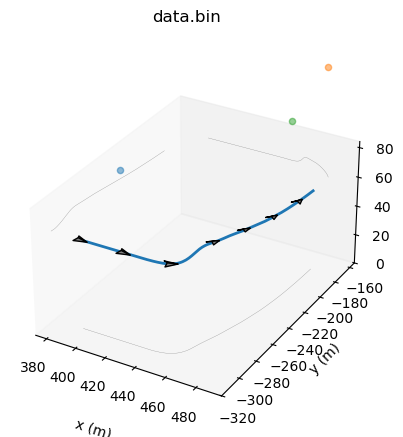

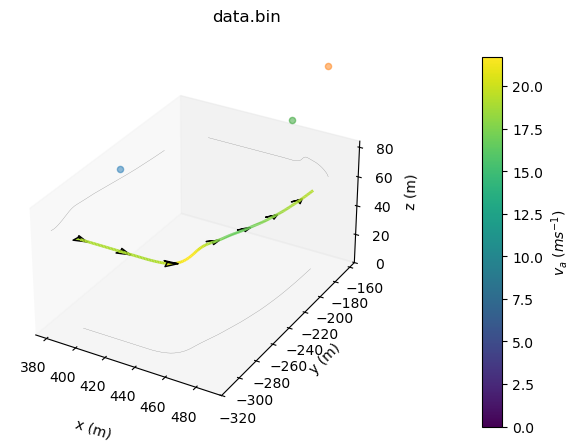

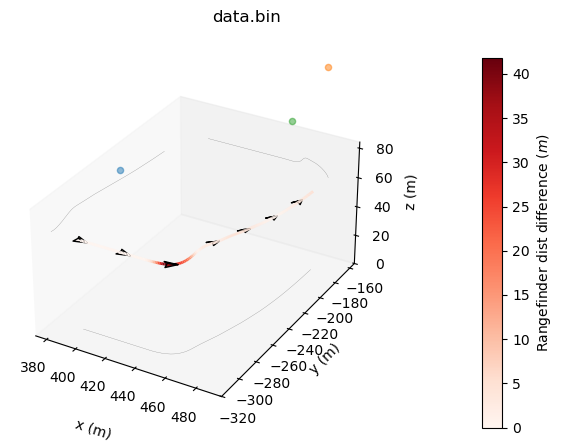

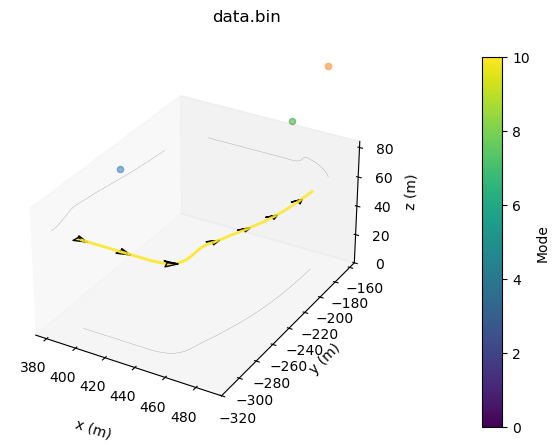

In [64]:
# Updates a trace for plotting. Done this way so that it can be used both with the static code and the
# animation.
def update_trace(plane_trace, xs, ys, zs, colouring_vals):
    points = np.array([xs, ys, zs]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # Update trace
    plane_trace.set_segments(segments)
    # Colour trace
    plane_trace.set_array(colouring_vals)

def gen_norm(colouring_vals, zero_centred_norm):
    min_val = np.min(np.concatenate((colouring_vals, [-0.01])))
    max_val = np.max(np.concatenate((colouring_vals, [0.01])))
    if zero_centred_norm:
        norm = colors.TwoSlopeNorm(vmin=min_val, vcenter=0, vmax=max_val)
    else:
        norm = colors.Normalize(min_val, max_val)
    
    return norm, min_val, max_val

# Plot trajectory
def plot_trajectory(colouring_vals=None, colouring_vals_label="", cmap_name='viridis', zero_centred_norm=False, traj_lw=2):
    fig = plt.figure()

    if colouring_vals is not None:
        gs = mpl.gridspec.GridSpec(1, 2, wspace=0.5, width_ratios=[0.95, 0.05])
        alt_ax = fig.add_subplot(gs[0, 0], projection='3d')
        cbar_ax = fig.add_subplot(gs[0, 1])
    else:
        alt_ax = fig.add_subplot(projection='3d')
    
    # Get data from POS (lat, lon, alt) and convert to NED coordinate system.
    ns = data.ns
    es = data.es
    ds = data.ds

    # Convert lat, lon, alt to ned
    xs, ys, zs = ned_to_xyz(ns, es, ds)
    if colouring_vals is None:
        alt_ax.plot(xs, ys, zs, zorder=2, lw=traj_lw)
    else:
        # Generate the norm
        norm, _, _ = gen_norm(colouring_vals, zero_centred_norm)
        # Create colourmap - for colouring trace by 'colouring_vals'
        cmap = mpl.colormaps[cmap_name]
        smap = mpl.cm.ScalarMappable(norm, cmap)
        # Create empty trace, then populate.
        plane_trace = art3d.Line3DCollection([], cmap=cmap, norm=norm, lw=traj_lw, zorder=2)
        update_trace(plane_trace, xs, ys, zs, colouring_vals)       # Populate trace
        # Add trace to axis
        alt_ax.add_collection(plane_trace)

    # Plot ground projection lines
    xlims = (np.min(xs) - 20, np.max(xs) + 20)
    ylims = (np.min(ys) - 20, np.max(ys) + 20)
    zlims = (0, np.max(zs) + 20)

    projn_col = 'grey'
    projn_lw = 0.2
    num_pts = xs.size
    alt_ax.plot(np.ones(num_pts)*xlims[0], ys, zs, c=projn_col, lw=projn_lw, zorder=0)
    alt_ax.plot(xs, np.ones(num_pts)*ylims[1], zs, c=projn_col, lw=projn_lw, zorder=0)
    alt_ax.plot(xs, ys, np.ones(num_pts)*zlims[0], c=projn_col, lw=projn_lw, zorder=0)

    # Plot planes
    for i in np.arange(0, len(xs), 30):
        if colouring_vals is None:
            c = 'grey'
        else:
            c = smap.to_rgba(colouring_vals[i])
        Plane(alt_ax, 3, xs[i], ys[i], zs[i], np.radians(data.phis[i]), np.radians(data.thetas[i]), np.radians(data.psis[i]), colour=c, zorder=4)

    # Plot waypoints and waypoint projections
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colours = prop_cycle.by_key()['color']
    for wp, col in zip(data.wps_ned[-3:], colours):
        wp_x, wp_y, wp_z = ned_to_xyz(wp[0], wp[1], wp[2])
        alt_ax.scatter(xlims[0], wp_y, wp_z, zorder=1, c=col, alpha=0.5)
        alt_ax.scatter(wp_x, ylims[1], wp_z, zorder=1, c=col, alpha=0.5)
        alt_ax.scatter(wp_x, wp_y, zlims[0], zorder=1, c=col, alpha=0.5)
        alt_ax.scatter(wp_x, wp_y, wp_z, zorder=3, c=col)

    alt_ax.grid(False)

    alt_ax.set_xlim(xlims)
    alt_ax.set_ylim(ylims)
    alt_ax.set_zlim(zlims)

    alt_ax.set_xlabel("\n\nx (m)")
    alt_ax.set_ylabel("y (m)")
    alt_ax.set_zlabel("z (m)")
    alt_ax.set_aspect('equal')

    if colouring_vals is not None:
        fig.colorbar(smap, cax=cbar_ax, label=colouring_vals_label)

    fig.suptitle(f"{data.name}")

# Colour by...
plot_trajectory()                                   # No colouring
plot_trajectory(data.vas, "$v_a$ ($m s^{-1}$)")     # Airspeed
# Rangefinder height difference
plot_trajectory(np.abs((data.rfnd_dist_ms - data.rfnd_dist_ms[0]) - (data.alt_ms_pos - data.alt_ms_pos[0])), "Rangefinder dist difference ($m$)", "Reds")
# Flight mode
mode_interp = make_interp_spline(data.mode_times_normalised_s, data.modes, k=0)
# - start_time_s to shift into normalised time
modes = mode_interp(data.time_values_s-data.start_time_s)[data.min_ind:data.max_ind]
plot_trajectory(modes, "Mode")

# Colour by groundspeed?

plt.show(block=True)

In [65]:
# Defining decorations

# Colour graph backgrounds by flight mode (e.g. MANUAL, AUTO, FBWA)
def overlay_modes(ax):
    norm = mpl.colors.Normalize(0, np.max(data.modes))
    smap = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
    for i in range(len(data.mode_times_normalised_s)-1):
        ax.axvspan(data.mode_times_normalised_s[i], data.mode_times_normalised_s[i+1], color=smap.to_rgba(data.modes[i]), alpha=0.1)
        # axs[4].axvline(data.mode_times_normalised_s[i], c='grey', ls='--', lw=0.5)
    ax.axvspan(data.mode_times_normalised_s[-1], data.normalised_time_values_s[-1], color=smap.to_rgba(data.modes[-1]), alpha=0.1)
    # axs[4].axvline(data.mode_times_normalised_s[-1], c='grey', ls='--', lw=0.5)

# ===

# Mark the start of the approach, the start of the flare and the landing with dashed lines.

# Find start times of approach and flare phases
# I don't think there is actually a switch to landing mode 2 - I think this is just because of the interpolation.
# TODO Is landing mode 2 the preflare?
land_stage_switches_s = data.normalised_times_s[np.where(np.round(data.land_stage[1:]) != np.round(data.land_stage[:-1]))]

# Find the landing time - get the last index where the rangefinder distance crosses 0.3m
# This might not be the most robust landing detection mechanism. Could also use the acceleration data (e.g. look for rapid decelerations).
landing_ind = find_peaks(-np.abs(data.rfnd_dist_ms - 0.3), height=-0.015)[0][-1]
landing_time = data.normalised_times_s[landing_ind]

# Plot start of approach, start of flare and landing times
def decorate_ax__landing_seqs(ax):
    ax.axvline(landing_time, c='red', ls='--', lw=1)
    for land_stage_switch_time_s in land_stage_switches_s:
        ax.axvline(land_stage_switch_time_s, lw=0.5, ls='--', c='grey')

IndexError: index -1 is out of bounds for axis 0 with size 0

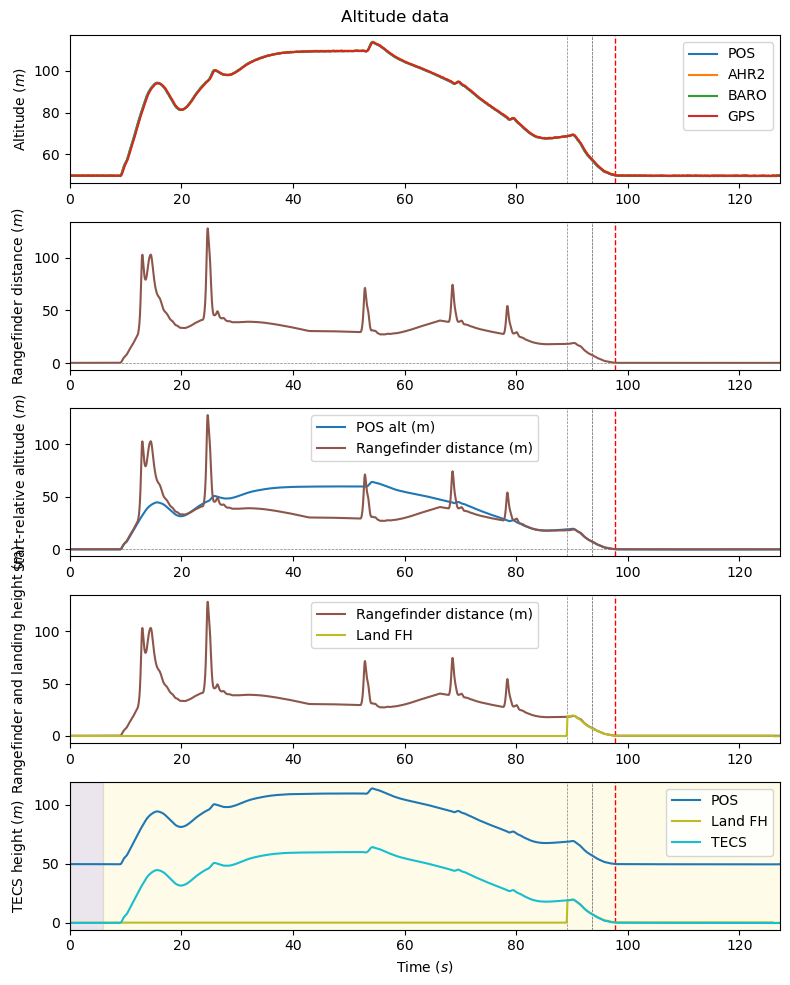

In [ ]:
# Plot different heights

fig, axs = plt.subplots(5, figsize=(8, 10))

prop_cycle = plt.rcParams['axes.prop_cycle']
colours = prop_cycle.by_key()['color']

# Altitude estimate from Kalman filter
pos_alt_ms = data.alt_ms_pos
# Backup altitude estimate
ahr2_alt_ms = data.alt_ms_ahr2
# Barometer altitude estimate
baro_alt_ms = data.alt_ms_baro_amsl
# GPS altitude estimate
gps_alt_ms = data.alt_ms_gps

# Rangefinder height
rfnd_dist_ms = data.rfnd_dist_ms
# TODO Which other sources of altitude data are there? And where do they come from - are they from the Kalman filter?

decorate_ax__landing_seqs(axs[0])
decorate_ax__landing_seqs(axs[1])
decorate_ax__landing_seqs(axs[2])
decorate_ax__landing_seqs(axs[3])
decorate_ax__landing_seqs(axs[4])

axs[0].plot(data.normalised_times_s, pos_alt_ms, label="POS", c=colours[0])
axs[0].plot(data.normalised_times_s, ahr2_alt_ms, label="AHR2", c=colours[1])
axs[0].plot(data.normalised_times_s, baro_alt_ms, label="BARO", c=colours[2])
axs[0].plot(data.normalised_times_s, gps_alt_ms, label="GPS", c=colours[3])
# axs[0].set_xlabel("Time ($s$)")
axs[0].set_ylabel("Altitude ($m$)")
axs[0].legend()

axs[1].plot(data.normalised_times_s, rfnd_dist_ms, c=colours[5])
axs[1].axhline(0, c='grey', lw=0.5, ls='--')
# axs[1].set_xlabel("Time ($s$)")
axs[1].set_ylabel("Rangefinder distance ($m$)")

# axs[2].plot(data.normalised_times_s, pos_alt_ms - pos_alt_ms[0], label="POS alt (m)", c=colours[0])
axs[2].plot(data.normalised_times_s, pos_alt_ms - data.get_start_pos_alt_ms(), label="POS alt (m)", c=colours[0])
axs[2].axhline(0, c='grey', lw=0.5, ls='--')
# axs[2].plot(data.normalised_times_s, rfnd_dist_ms - rfnd_dist_ms[0], label="Rangefinder distance (m)", c=colours[5])
axs[2].plot(data.normalised_times_s, rfnd_dist_ms - data.get_start_rfnd_dist_ms(), label="Rangefinder distance (m)", c=colours[5])
axs[2].set_ylabel("Start-relative altitude ($m$)")
axs[2].legend()

axs[3].plot(data.normalised_times_s, rfnd_dist_ms, label="Rangefinder distance (m)", c=colours[5])
axs[3].plot(data.normalised_times_s, data.land_fh, label="Land FH", c=colours[8])
axs[3].set_ylabel("Rangefinder and landing height ($m$)")
axs[3].legend()

overlay_modes(axs[4])
axs[4].plot(data.normalised_times_s, pos_alt_ms, label="POS", c=colours[0])
axs[4].plot(data.normalised_times_s, data.land_fh, label="Land FH", c=colours[8])
axs[4].plot(data.normalised_times_s, data.tecs_h, label="TECS", c=colours[9])
axs[4].set_ylabel("TECS height ($m$)")
axs[4].set_xlabel("Time ($s$)")
axs[4].legend()

axs[0].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))
axs[1].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))
axs[2].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))
axs[3].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))
axs[4].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))

fig.suptitle("Altitude data")

fig.tight_layout()
plt.show(block=True)

# Q. Which altitude source is used in the autolanding?

Text(0, 0.5, 'Land FH')

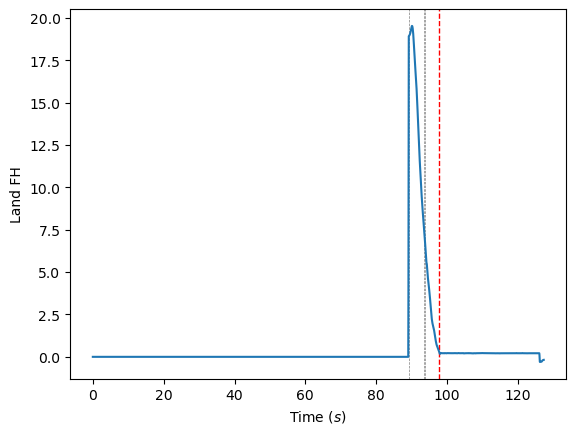

In [ ]:
fig, ax = plt.subplots()
decorate_ax__landing_seqs(ax)
ax.plot(data.normalised_times_s, data.land_fh)
ax.set_xlabel("Time ($s$)")
ax.set_ylabel("Land FH")

In [ ]:
# Return the index in the lists at which the aircraft is first within rad metres of the given (n, e, d) location
def ind_at_waypoint(data, n, e, d, rad=10):
    # How to solve this - need all three to be in rad metres
    valid_inds = (np.abs(n - data.ns) < rad) & (np.abs(e - data.es) < rad) & (np.abs(d - data.ds) < rad)
    init_ind = np.where(valid_inds)[0][0]
    return init_ind

truncate_ind = ind_at_waypoint(data, *data.wps_ned[-3], rad=10)

# Rotate the data into the coordinate system of the line from the final approach waypoint to the landing waypoint
# Get final approach and landing waypoints
pre_app_wp_ne = np.array(data.wps_ned[-3][:2])
final_app_wp_ne = np.array(data.wps_ned[-2][:2])
landing_wp_ne = np.array(data.wps_ned[-1][:2])

# Calculate direction between them
dir = landing_wp_ne - final_app_wp_ne

# Get the angle of the vector
rotat_angle = np.arctan2(dir[1], dir[0])    # This angle should be in radians

# Find the coordinate transformation rotation matrix
rotat = np.array([[np.cos(rotat_angle), np.sin(rotat_angle)], [-np.sin(rotat_angle), np.cos(rotat_angle)]])

# Do a coordinate transformation on the data
# This is centred on the landing waypoint
ne_vals_rotated = rotat @ (np.array([data.ns, data.es]) - landing_wp_ne.reshape((2, 1))) # - (rotat @ landing_wp_ne).reshape((2,1)) # np.array([landing_wp_ne]).T

# Get the in-plane and out-of-plane positions
in_plane, out_of_plane = ne_vals_rotated

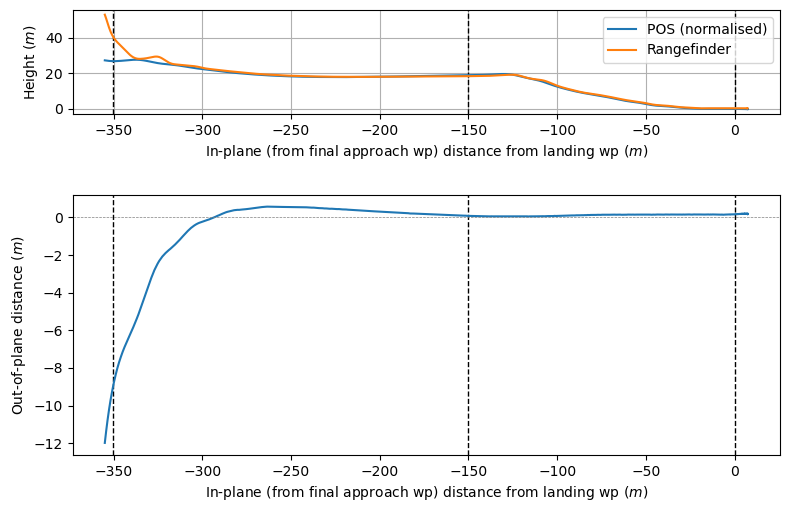

In [ ]:
# Plot the glide slope and out-of-plane-ness
# Plot the altitude and the rangefinder height

# Get the in-plane distances of the waypoints
pre_app_wp_rotat = rotat @ (pre_app_wp_ne - landing_wp_ne)
final_app_wp_rotat = rotat @ (final_app_wp_ne - landing_wp_ne)

fig, axs = plt.subplots(2, figsize=(8, 6))
axs[0].axvline(pre_app_wp_rotat[0], c='k', lw=1, ls='--')
axs[0].axvline(final_app_wp_rotat[0], c='k', lw=1, ls='--')
axs[0].axvline(0, c='k', lw=1, ls='--')
# in_plane gives the distance from the landing point
axs[0].plot(in_plane[truncate_ind:], -data.ds[truncate_ind:], label="POS (normalised)")
axs[0].plot(in_plane[truncate_ind:], data.rfnd_dist_ms[truncate_ind:], label="Rangefinder")
axs[0].set_xlabel("In-plane (from final approach wp) distance from landing wp ($m$)")
axs[0].set_ylabel("Height ($m$)")
axs[0].legend()
axs[0].grid()
axs[0].set_aspect('equal')

axs[1].axvline(pre_app_wp_rotat[0], c='k', lw=1, ls='--')
axs[1].axvline(final_app_wp_rotat[0], c='k', lw=1, ls='--')
axs[1].axvline(0, c='k', lw=1, ls='--')
axs[1].plot(in_plane[truncate_ind:], out_of_plane[truncate_ind:])
axs[1].set_xlabel("In-plane (from final approach wp) distance from landing wp ($m$)")
axs[1].set_ylabel("Out-of-plane distance ($m$)")
axs[1].axhline(0, c='grey', ls='--', lw=0.5)

fig.tight_layout()

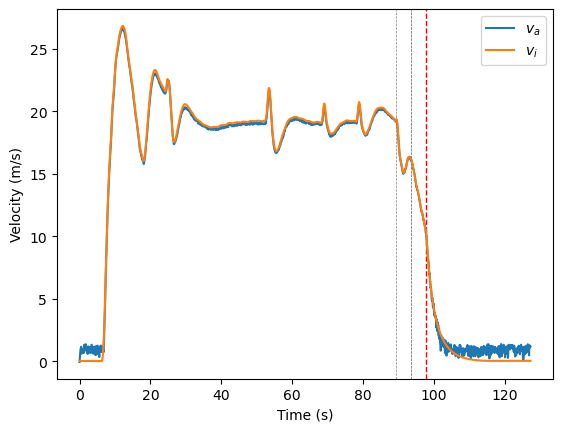

In [ ]:
# Plot airspeed and groundspeed

# TODO Crude estimate of groundspeed - needs improving
vis = np.sqrt(data.vn_xkf1_m**2 + data.ve_xkf1_m**2 + data.vd_xkf1_m**2)

fig, ax = plt.subplots()
decorate_ax__landing_seqs(ax)
ax.plot(data.normalised_times_s, data.vas, label="$v_a$")
ax.plot(data.normalised_times_s, vis, label="$v_i$")
ax.set_ylabel("Velocity (m/s)")
ax.set_xlabel("Time (s)")
ax.legend()

[-0.          0.02250504  0.03500985 ...  0.16999817  0.16999817
  0.16497225]


Text(0.5, 0.98, 'Inertial sink rate')

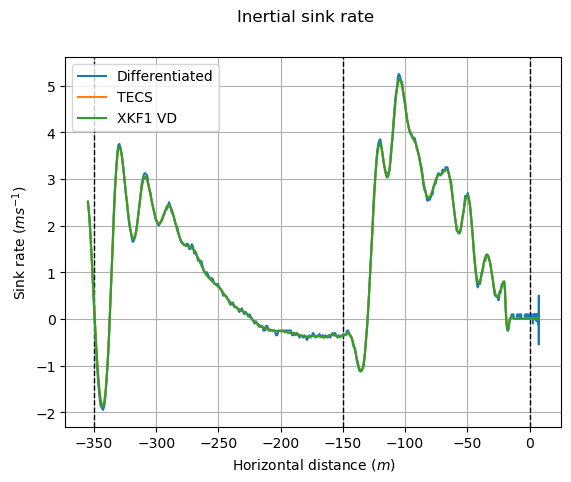

In [ ]:
# Plot the sink rate
# Numerically differentiate height to get sink rate
sink_rate = np.gradient(data.ds, data.times_s)

# print(pre_app_wp_ne)

print(data.ds)

fig, ax = plt.subplots()
ax.axvline(pre_app_wp_rotat[0], c='k', lw=1, ls='--')
ax.axvline(final_app_wp_rotat[0], c='k', lw=1, ls='--')
ax.axvline(0, c='k', lw=1, ls='--')
ax.plot(in_plane[truncate_ind:], sink_rate[truncate_ind:], label="Differentiated")
ax.plot(in_plane[truncate_ind:], -data.tecs_dh[truncate_ind:], label="TECS")
ax.plot(in_plane[truncate_ind:], data.vd_xkf1_m[truncate_ind:], label="XKF1 VD")
ax.set_xlabel("Horizontal distance ($m$)")
ax.set_ylabel("Sink rate ($ms^{-1}$)")
ax.legend()
ax.grid()
fig.suptitle("Inertial sink rate")

# Control

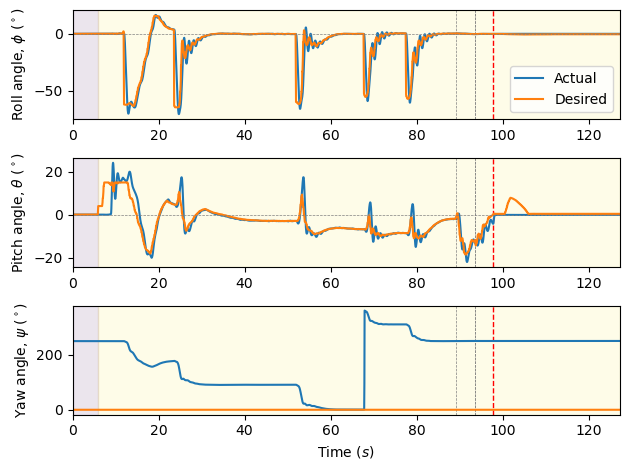

In [ ]:
# Plot inner loop demands
# TODO Colour by the landing stages

fig, axs = plt.subplots(3)

overlay_modes(axs[0])
decorate_ax__landing_seqs(axs[0])
axs[0].plot(data.normalised_times_s, data.phis, label="Actual")
axs[0].plot(data.normalised_times_s, data.phis_des, label="Desired")
axs[0].axhline(0, ls='--', c='grey', lw=0.5)
axs[0].set_ylabel(r"Roll angle, $\phi$ ($^\circ$)")
axs[0].legend()

overlay_modes(axs[1])
decorate_ax__landing_seqs(axs[1])
axs[1].plot(data.normalised_times_s, data.thetas, label="Actual")
axs[1].plot(data.normalised_times_s, data.thetas_des, label="Desired")
axs[1].axhline(0, ls='--', c='grey', lw=0.5)
axs[1].set_ylabel(r"Pitch angle, $\theta$ ($^\circ$)")

overlay_modes(axs[2])
decorate_ax__landing_seqs(axs[2])
axs[2].plot(data.normalised_times_s, data.psis, label="Actual")
axs[2].plot(data.normalised_times_s, data.psis_des, label="Desired")
axs[2].set_xlabel("Time ($s$)")
axs[2].set_ylabel(r"Yaw angle, $\psi$ ($^\circ$)")

axs[0].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))
axs[1].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))
axs[2].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))

fig.tight_layout()


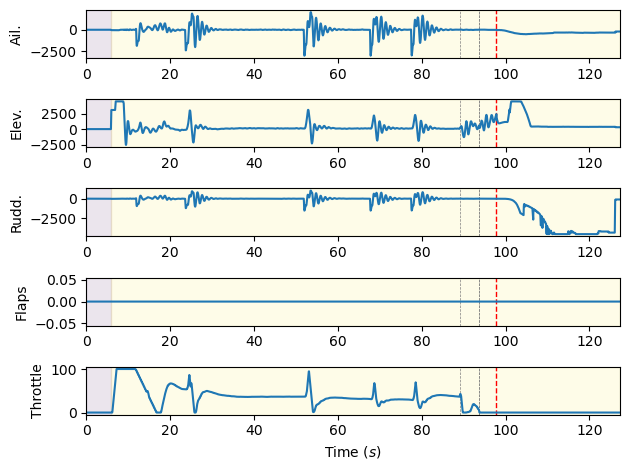

In [ ]:
# Plot control surface actuations (pitch, roll, yaw, flaps, throttle)

fig, axs = plt.subplots(5)

overlay_modes(axs[0])
decorate_ax__landing_seqs(axs[0])
axs[0].plot(data.normalised_times_s, data.ctrl_as)
axs[0].set_ylabel("Ail.")

overlay_modes(axs[1])
decorate_ax__landing_seqs(axs[1])
axs[1].plot(data.normalised_times_s, data.ctrl_es)
axs[1].set_ylabel("Elev.")

overlay_modes(axs[2])
decorate_ax__landing_seqs(axs[2])
axs[2].plot(data.normalised_times_s, data.ctrl_rs)
axs[2].set_ylabel("Rudd.")

overlay_modes(axs[3])
decorate_ax__landing_seqs(axs[3])
axs[3].plot(data.normalised_times_s, data.ctrl_flaps)
axs[3].set_ylabel("Flaps")

overlay_modes(axs[4])
decorate_ax__landing_seqs(axs[4])
axs[4].plot(data.normalised_times_s, data.ctrl_ts)
axs[4].set_ylabel("Throttle")
axs[4].set_xlabel("Time ($s$)")

axs[0].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))
axs[1].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))
axs[2].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))
axs[3].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))
axs[4].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))

fig.tight_layout()

### TECS output

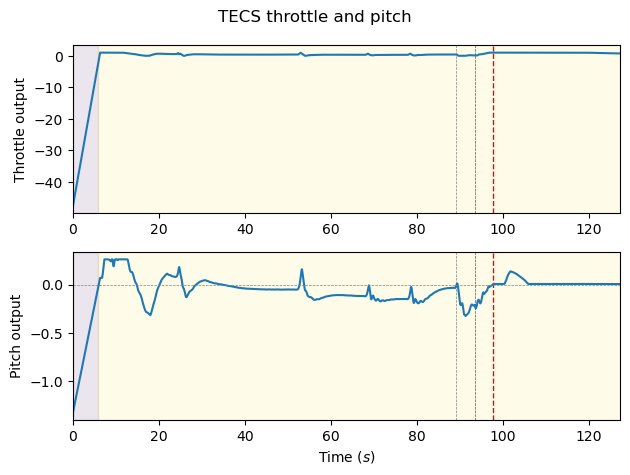

In [ ]:
# TECS throttle and pitch

fig, axs = plt.subplots(2)

overlay_modes(axs[0])
decorate_ax__landing_seqs(axs[0])
axs[0].plot(data.normalised_times_s, data.tecs_th)
axs[0].set_ylabel("Throttle output")

overlay_modes(axs[1])
decorate_ax__landing_seqs(axs[1])
axs[1].plot(data.normalised_times_s, data.tecs_ph)
axs[1].set_ylabel("Pitch output")
axs[1].axhline(0, ls='--', c='grey', lw=0.5)
axs[1].set_xlabel("Time ($s$)")

axs[0].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))
axs[1].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))

# fig.legend()
fig.suptitle("TECS throttle and pitch")
fig.tight_layout()

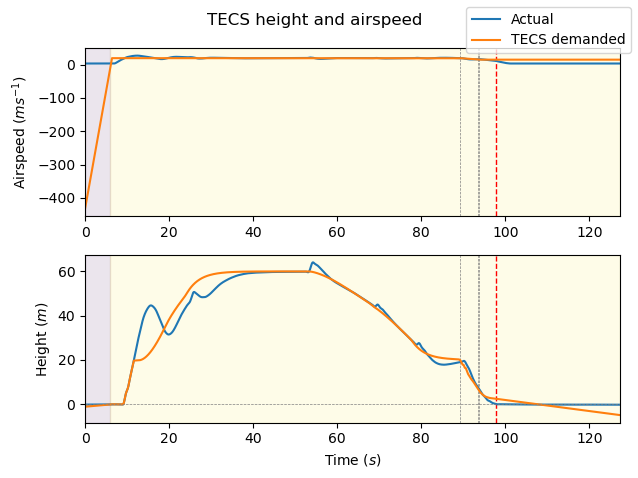

In [ ]:
# TECS height and speed

fig, axs = plt.subplots(2)

overlay_modes(axs[0])
decorate_ax__landing_seqs(axs[0])
axs[0].plot(data.normalised_times_s, data.tecs_sp, label="Actual")
axs[0].plot(data.normalised_times_s, data.tecs_spdem, label="TECS demanded")
axs[0].set_ylabel("Airspeed ($ms^{-1}$)")

overlay_modes(axs[1])
decorate_ax__landing_seqs(axs[1])
axs[1].plot(data.normalised_times_s, data.tecs_h)
axs[1].plot(data.normalised_times_s, data.tecs_hdem)
axs[1].axhline(0, ls='--', c='grey', lw=0.5)
axs[1].set_ylabel("Height ($m$)")
axs[1].set_xlabel("Time ($s$)")

axs[0].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))
axs[1].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))

fig.legend()
fig.suptitle("TECS height and airspeed")
fig.tight_layout()

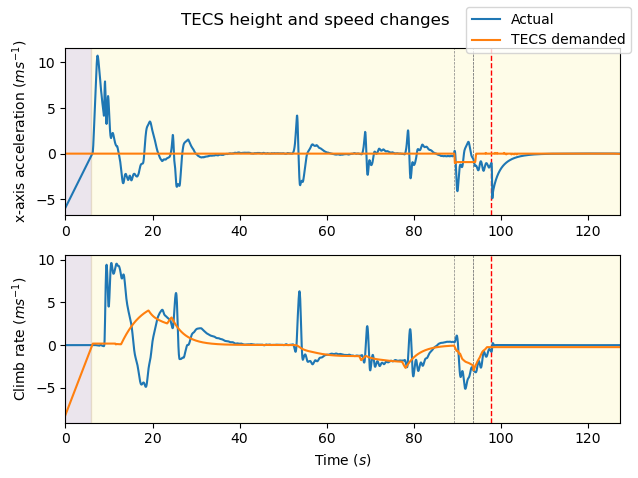

In [ ]:
# TECS height and speed changes
# TODO These are the units listed on plot.ardupilot.org, but are they wrong?

fig, axs = plt.subplots(2)

overlay_modes(axs[0])
decorate_ax__landing_seqs(axs[0])
axs[0].plot(data.normalised_times_s, data.tecs_dsp, label="Actual")
axs[0].plot(data.normalised_times_s, data.tecs_dspdem, label="TECS demanded")
axs[0].set_ylabel("x-axis acceleration ($ms^{-1}$)")

overlay_modes(axs[1])
decorate_ax__landing_seqs(axs[1])
axs[1].plot(data.normalised_times_s, data.tecs_dh)
axs[1].plot(data.normalised_times_s, data.tecs_dhdem)
axs[1].set_ylabel("Climb rate ($ms^{-1}$)")
axs[1].set_xlabel("Time ($s$)")

axs[0].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))
axs[1].set_xlim(np.min(data.normalised_times_s), np.max(data.normalised_times_s))

fig.legend()
fig.suptitle("TECS height and speed changes")
fig.tight_layout()